In [9]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn for preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# TensorFlow / Keras for neural networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


# Load data
bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

In [6]:
print(daily['dteday'].max())
print(daily.tail())


2023-10-31 00:00:00
         dteday     temp_c  feels_like_c       hum  windspeed  holiday  \
4682 2023-10-27  20.225000     20.229167  0.730217   8.341667        0   
4683 2023-10-28  21.537500     21.537500  0.712254   7.250000        0   
4684 2023-10-29  20.595833     20.595833  0.780079   8.904167        0   
4685 2023-10-30  17.129167     17.129167  0.762071  16.133333        0   
4686 2023-10-31  10.258333      9.562500  0.513467  12.762500        0   

      workingday  season  weathersit  casual  registered  count  day_of_week  \
4682           1       4    1.166667    6894       11689  18583            4   
4683           0       4    1.041667    9505       10669  20174            5   
4684           0       4    1.375000    7965        9199  17164            6   
4685           1       4    1.625000    4005        9180  13185            0   
4686           1       4    1.458333    4072       10630  14702            1   

      month   day_sin   day_cos  month_sin  month_cos 

In [10]:
#Chunk 1: Data Preparation (Updated for Dictionary)

# Parse date and create datetime features
bikes['dteday'] = pd.to_datetime(bikes['dteday'])

# Group by day to get total rentals per day
daily = bikes.groupby('dteday').agg({
    'temp_c': 'mean',
    'feels_like_c': 'mean',
    'hum': 'mean',
    'windspeed': 'mean',
    'holiday': 'first',
    'workingday': 'first',
    'season': 'first',
    'weathersit': 'mean',
    'casual': 'sum',
    'registered': 'sum'
}).reset_index()

# Create total count
daily['count'] = daily['casual'] + daily['registered']

# Time-based features
daily['day_of_week'] = daily['dteday'].dt.dayofweek
daily['month'] = daily['dteday'].dt.month

# Cyclical encoding for day of week and month
daily['day_sin'] = np.sin(2 * np.pi * daily['day_of_week'] / 7)
daily['day_cos'] = np.cos(2 * np.pi * daily['day_of_week'] / 7)
daily['month_sin'] = np.sin(2 * np.pi * daily['month'] / 12)
daily['month_cos'] = np.cos(2 * np.pi * daily['month'] / 12)

# Final features
features = ['temp_c', 'feels_like_c', 'hum', 'windspeed', 'holiday',
            'workingday', 'season', 'weathersit', 'day_sin', 'day_cos',
            'month_sin', 'month_cos']
target = 'count'

# Use October for testing
train_bikes = daily[daily['dteday'] < '2023-10-01']
test_bikes = daily[(daily['dteday'] >= '2023-10-01') & (daily['dteday'] <= '2023-10-31')]


X_train = train_bikes[features]
y_train = train_bikes[target]
X_test = test_bikes[features]
y_test = test_bikes[target]

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 70424816.0000 - val_loss: 113714456.0000
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 69319712.0000 - val_loss: 108094120.0000
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 65332012.0000 - val_loss: 93672584.0000
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 53595780.0000 - val_loss: 71537792.0000
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39475808.0000 - val_loss: 48906092.0000
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25133076.0000 - val_loss: 33694528.0000
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17806370.0000 - val_loss: 25685034.0000
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14929171.0000 - val_loss: 21343044.0000
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13379225.0000 - val_loss: 18579612.0000
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11583489.0000 - val_loss: 16696055.0000

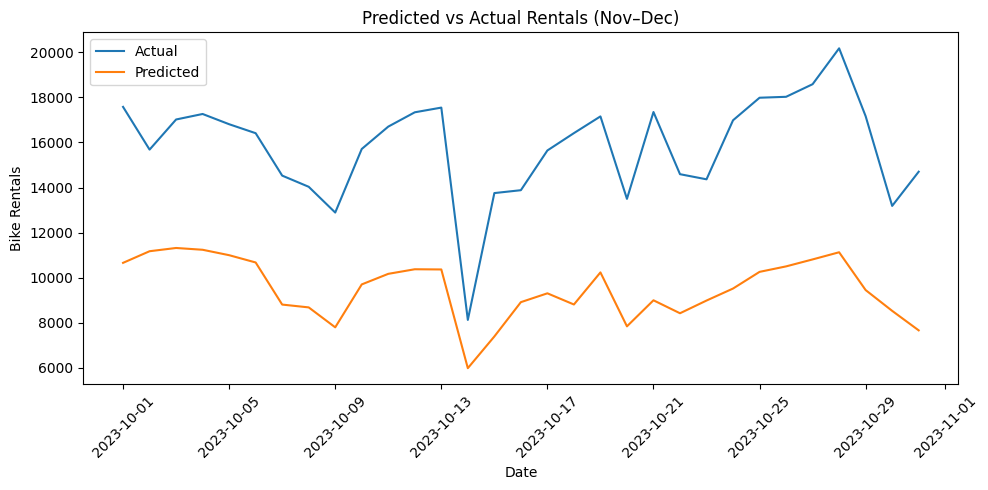

In [11]:
#Chunk 2: Model Training, Prediction, and Visualization

# Build the model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train,
                    validation_split=0.2,
                    epochs=100,
                    callbacks=[early_stop],
                    verbose=1)

# Predict on test data (Nov–Dec)
predictions = model.predict(X_test_scaled).flatten()

# Create results DataFrame
results = test_bikes[['dteday']].copy()
results['predicted_count'] = predictions
results['actual_count'] = y_test.values

# Save predictions to CSV
results.to_csv('bike_predictions_nov_dec.csv', index=False)

# Plot predictions vs actuals
plt.figure(figsize=(10,5))
plt.plot(results['dteday'], results['actual_count'], label='Actual')
plt.plot(results['dteday'], results['predicted_count'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Bike Rentals')
plt.title('Predicted vs Actual Rentals (Nov–Dec)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

